In [474]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime

In [475]:
ofi = pd.read_csv('../data_cleaned/ofi_10_levels.csv')
OFI_values = ofi.drop(['mid_price_delta', 'time_bin', 'bin_label'], axis=1)

## Multivariate Time Series Forecasting with LSTMs

In [487]:
time_series = ofi.drop(['bin_label', 'time_bin'], axis=1)
time_series.index.name = 'date'
time_series.index = ofi['time_bin'].apply(lambda x: datetime.strptime(ofi['time_bin'][0][1:27],"%Y-%m-%d %H:%M:%S.%f" ))

Index(['OFI_0', 'OFI_1', 'OFI_2', 'OFI_3', 'OFI_4', 'OFI_5', 'OFI_6', 'OFI_7',
       'OFI_8', 'OFI_9', 'mid_price_delta'],
      dtype='object')


[Text(0, -40000000.0, ''),
 Text(0, -30000000.0, ''),
 Text(0, -20000000.0, ''),
 Text(0, -10000000.0, ''),
 Text(0, 0.0, ''),
 Text(0, 10000000.0, ''),
 Text(0, 20000000.0, ''),
 Text(0, 30000000.0, ''),
 Text(0, 40000000.0, '')]

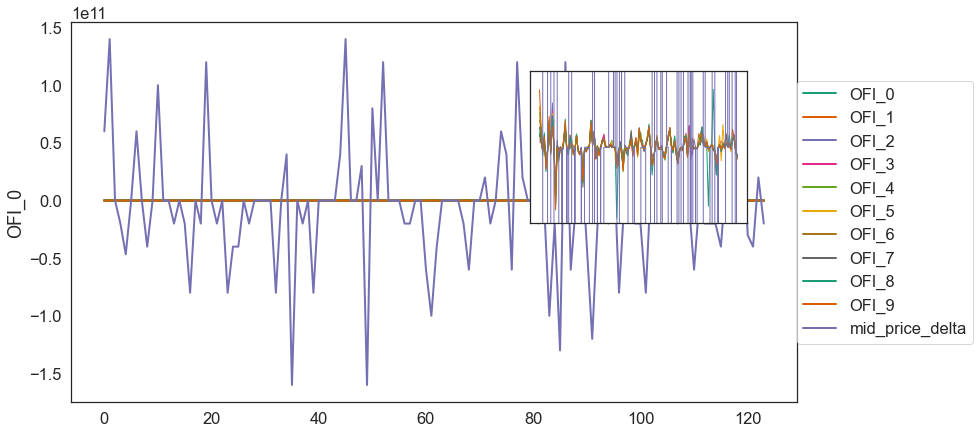

In [540]:
#time evoltion
import matplotlib.pyplot as plt
import seaborn as sns
ms = 0
lw = 2
fig, ax = plt.subplots(figsize=(13,7))

for c in time_series.columns:
    g = sns.lineplot(x=np.arange(len(time_series)), y=time_series[c] , ax=ax, 
                linewidth=lw, marker='o', markersize=ms, label=c)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=0.)

# An inner plot to show the peak frequency
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
axins = inset_axes(ax,  "30%", "40%" ,loc="upper right", borderpad=3)
for c in time_series.columns:
    g = sns.lineplot(x=np.arange(len(time_series)), y=time_series[c] , ax=axins, 
                linewidth=1, marker='o', markersize=ms, label=c)
axins.get_legend().remove()
axins.set_ylim(-3.5e7,3.5e7)
axins.set_ylabel('')
axins.set_xlabel('')
axins.set_xticklabels([])
axins.set_yticklabels([])

Text(0, 0.5, 'Power')

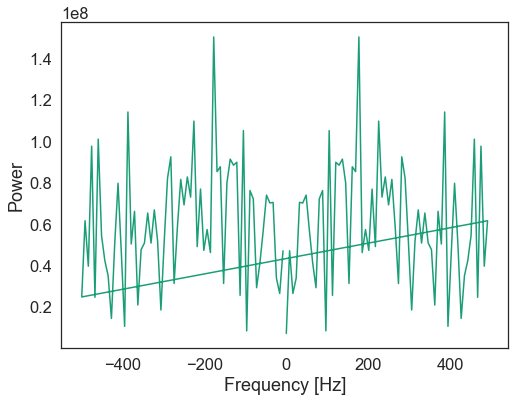

In [558]:
# fft
from scipy.fftpack import fft, fftfreq
time_step = 1e-3
sig = time_series['OFI_0'].to_numpy()
sig_fft = fft(sig)
power = np.abs(sig_fft) 

sample_freq = fftfreq(sig.size, d=time_step)

# Plot the FFT power
plt.figure(figsize=(8, 6))
plt.plot(sample_freq, power)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power')

Epoch 1/50
2/2 - 2s - loss: 0.4047 - val_loss: 0.3242 - 2s/epoch - 872ms/step
Epoch 2/50
2/2 - 0s - loss: 0.3355 - val_loss: 0.2487 - 23ms/epoch - 11ms/step
Epoch 3/50
2/2 - 0s - loss: 0.2698 - val_loss: 0.1784 - 24ms/epoch - 12ms/step
Epoch 4/50
2/2 - 0s - loss: 0.2123 - val_loss: 0.1171 - 23ms/epoch - 12ms/step
Epoch 5/50
2/2 - 0s - loss: 0.1668 - val_loss: 0.0813 - 28ms/epoch - 14ms/step
Epoch 6/50
2/2 - 0s - loss: 0.1449 - val_loss: 0.0918 - 30ms/epoch - 15ms/step
Epoch 7/50
2/2 - 0s - loss: 0.1503 - val_loss: 0.1161 - 29ms/epoch - 14ms/step
Epoch 8/50
2/2 - 0s - loss: 0.1653 - val_loss: 0.1270 - 40ms/epoch - 20ms/step
Epoch 9/50
2/2 - 0s - loss: 0.1717 - val_loss: 0.1230 - 37ms/epoch - 19ms/step
Epoch 10/50
2/2 - 0s - loss: 0.1680 - val_loss: 0.1092 - 41ms/epoch - 21ms/step
Epoch 11/50
2/2 - 0s - loss: 0.1577 - val_loss: 0.0924 - 42ms/epoch - 21ms/step
Epoch 12/50
2/2 - 0s - loss: 0.1470 - val_loss: 0.0783 - 35ms/epoch - 18ms/step
Epoch 13/50
2/2 - 0s - loss: 0.1423 - val_loss: 0.

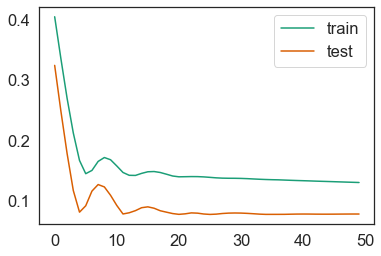

NameError: name 'inv_y' is not defined

In [555]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	if dropnan:
		agg.dropna(inplace=True)
	return agg

from sklearn.preprocessing import MinMaxScaler
values = time_series.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)

values = reframed.values
train_frac = 0.8
test_frac = 0.2

train = values[:int(train_frac*len(time_series)), :]
test = values[int(train_frac*len(time_series)):, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# design network
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
				validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# # make a prediction
# yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# calculate RMSE
# from sklearn.metrics import mean_squared_error
# rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
# print('Test RMSE: %.3f' % rmse)



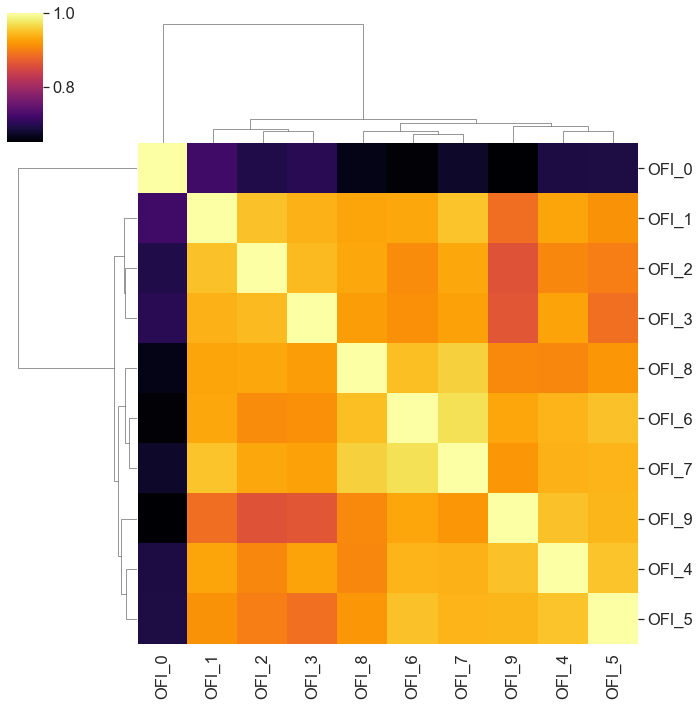

In [455]:
sns.clustermap(OFI_values.corr(), cmap='inferno',  )

<AxesSubplot:xlabel='mid_price_delta', ylabel='Count'>

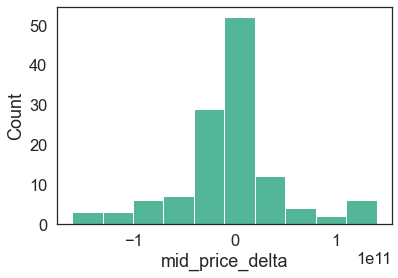

In [456]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(x='mid_price_delta',data=ofi, bins=10)

explained variance ratio: [0.89429368 0.04842077 0.02122749 0.01028081 0.00667304 0.00601991
 0.00517373 0.00334368 0.00260536 0.00196153]


/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


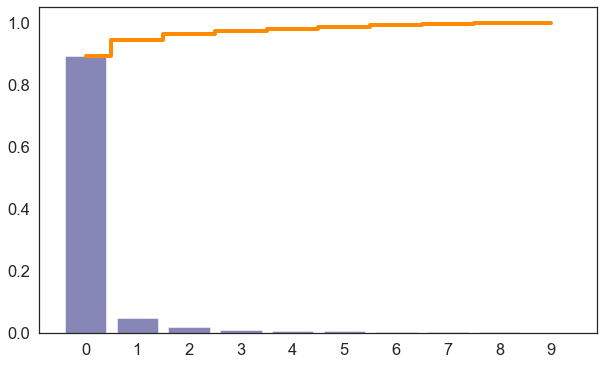

In [457]:
#pca reduction
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(OFI_values) 
pca = PCA(n_components=None)
pca.fit(scaled)
new_ofi = pca.transform(scaled)


fig, ax = plt.subplots(figsize=(10,6))
sns.set_theme(style='white', font_scale=1.5, palette = 'magma')

explained_var = pca.explained_variance_ratio_
print('explained variance ratio: {}'.format(explained_var))
sns.barplot(np.arange(len(explained_var)), explained_var, alpha=0.5, color = 'navy' )

plt.step(np.arange(len(explained_var)), np.cumsum(explained_var), 
            drawstyle='steps-pre', color='darkorange', lw=4, where = 'mid')

<AxesSubplot:xlabel='mid_price_delta', ylabel='OFI_0'>

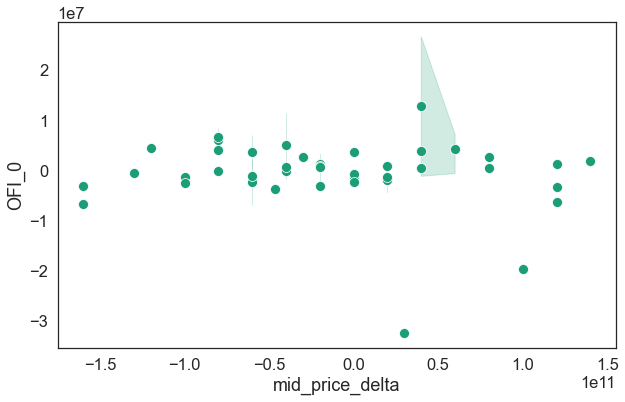

In [458]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style='white', palette='Dark2', font_scale=1.5)
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(x='mid_price_delta', y='OFI_0', data=ofi, ax=ax, linewidth = 0, markersize=10, marker='o')